In [ ]:
import numpy as np


class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [ ]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        if input_img.ndim == 3:
            img_h, img_w, img_c = input_img.shape
        elif input_img.ndim == 2:
            img_h, img_w = input_img.shape

        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            if input_img.ndim == 3:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            if input_img.ndim == 2:
                c = np.random.uniform(v_l, v_h, (h, w))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w] = c

        return input_img

    return eraser

(50000, 32, 32, 3)
(10000, 32, 32, 3)
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_308 (Conv2D)             (None, 32, 32, 16)   448         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_284 (BatchN (None, 32, 32, 16)   64          conv2d_308[0][0]                 
__________________________________________________________________________________________________
activation_284 (Activation)     (None, 32, 32, 16)   0           batch_normalization_284[0][0]    
______________________________________________________

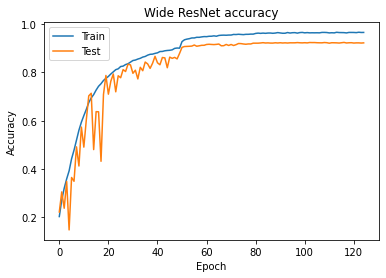

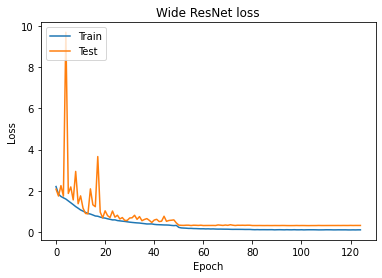

In [ ]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input,add,Add
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D,AveragePooling2D
from keras.layers.normalization import BatchNormalization 
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator

batch_size = 128
num_classes = 10
epochs = 125


#### LOAD AND TRANSFORM
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)
datagen = ImageDataGenerator(
    width_shift_range=0.125,
    height_shift_range=0.125,
    horizontal_flip=True,
    preprocessing_function=get_random_eraser(v_l=0, v_h=1))
training_generator = MixupGenerator(x_train, y_train, batch_size=batch_size, alpha=0.7, datagen=datagen)()

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

def input_block(input, filtros):
  x = Conv2D(16, (3, 3), padding='same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

def conv_block_wideresnet(input, filters=16, k=1, dropout=0.0, N=0):
  x_res = Conv2D(filters * k, (1, 1), padding='same',strides=2)(input)

  x = Conv2D(filters * k, (3, 3), padding='same',strides=2)(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  if dropout > 0.0:
    x = Dropout(dropout)(x)

  x = Conv2D(filters * k, (3, 3), padding='same')(x)
  x_out = Add()([x, x_res])
  for b in range(N-1):
    x = BatchNormalization()(x_out)
    x = Activation('relu')(x)
    x = Conv2D(filters * k, (3, 3), padding='same')(x)
    if dropout > 0.0:
      x = Dropout(dropout)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters * k, (3, 3), padding='same')(x)
    x_out = Add()([x,x_out])
  
  x = BatchNormalization()(x_out)
  x = Activation('relu')(x)
  return x


# WIDE RESNET
prof = 28
N = (prof - 4)//6
k = 10
dropout = 0.0

img_input = Input(shape= (x_train.shape[1:]))
x = input_block(img_input,16)
x = conv_block_wideresnet(x, 16 , k , dropout,N)
x = conv_block_wideresnet(x, 32 , k , dropout,N)
x = conv_block_wideresnet(x, 64 , k , dropout,N)
dim1 = x.shape[1]
x = AveragePooling2D(pool_size=dim1)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
out = Dense(num_classes, activation='softmax')(x)


model = Model(img_input, out)

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

def scheduler(epoch):
    if epoch < 50:
        return .1
    elif epoch < 80:
        return 0.01
    else:
        return 0.001

set_lr = LRS(scheduler)

history=model.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            callbacks=[set_lr],
                            verbose=1)


## TEST
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Wide ResNet accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Wide ResNet loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
